In [44]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example loads and explores the MNIST dataset. The dataset first needs to be downloaded and decompressed into the ../data/mnist directory (see README file). More context for this code example can be found in the section "Exploring the dataset" in Chapter 4 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).

The first code snippet shows how we load the files into NumPy arrays and then print the dimensions of these arrays. The file format is not a standard image format, but it is easy to read the files using the idx2numpy library. The dataset is assumed to be in the directory ../data/mnist/hand/.

In [45]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
print(f"Train shape: {train_images.shape}, Test shape: {test_images.shape}")
print(f"Train labels: {train_labels.shape}, Test labels: {test_labels.shape}")

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)
Train labels: (60000,), Test labels: (10000,)


The next code snippet prints out the first training label and image pattern.

In [46]:
# Print one training example.
print('label for first training example: ', train_labels[0])
print('---beginning of pattern for first training example---')
for line in train_images[0]:
    for num in line:
        if num > 0:
            print('*', end = ' ')
        else:
            print(' ', end = ' ')
    print('')
print('---end of pattern for first training example---')

label for first training example:  9
---beginning of pattern for first training example---
                                                        
                                                        
                                                        
                        *     * *     * *         * *   
                        *   * * * * *       * * *     * 
                        *   * * * * * * *         * *   
                            * * * * * * * * * * * * * * 
                      *   * * * * * * * * * * * * * * * 
                  * * *   * * * * * * * * * * * * * *   
                          * * * * * * * * * * * * * *   
                          * * * * * * * * * * * * * *   
                  * *   * * * * * * * * * * * * * * * * 
                    *   * * * * * * * * * * * * * * * * 
                  *     * * * * * * * * * * * * * * *   
    * * * * *           * * * * * * * * * * * * * * *   
  *               * * * * * * * * * * * * * * * * * * 

Now we trains the two-level network to classify handwritten digits using the MNIST dataset.

In [47]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7) # To make repeatable
LEARNING_RATE = 0.01
EPOCHS = 20

We have also added a function to read the datasets from files, as shown in the next code snippet. To simplify feeding the input data to the network, we reshape the images from two dimensions into a single dimension. That is, the arrays of images are now 2D instead of 3D. After this, we scale the pixel values and center them around 0. This is known as standardizing the data. We first compute the mean and standard deviation of all the training values. We standardize the data by subtracting the mean from each pixel value and dividing by the standard deviation.

The next step is to one-hot encode the digit number to be used as a ground truth for our ten-output network. We one-hot encode by creating an array of ten numbers, each being 0 (using the NumPy zeros function), and then set one of them to 1.

In [48]:
# Function to read dataset.
def read_mnist(train_images, train_labels, test_images, test_labels):
    # Reformat and standardize.
    x_train = train_images.reshape(60000, 784)
    mean = np.mean(x_train)
    stddev = np.std(x_train)
    x_train = (x_train - mean) / stddev
    x_test = test_images.reshape(10000, 784)
    x_test = (x_test - mean) / stddev

    # One-hot encoded output.
    y_train = np.zeros((60000, 10))
    y_test = np.zeros((10000, 10))
    for i, y in enumerate(train_labels):
        y_train[i][y] = 1
    for i, y in enumerate(test_labels):
        y_test[i][y] = 1
    return x_train, y_train, x_test, y_test

# Read train and test examples.
x_train, y_train, x_test, y_test = read_mnist(train_images, train_labels, test_images, test_labels)
index_list = list(range(len(x_train))) # Used for random order
print("y_train shape:", y_train.shape)
print("Unique labels in train_labels:", np.unique(train_labels))
print("Number of classes (should be 10):", len(np.unique(train_labels)))

y_train shape: (60000, 10)
Unique labels in train_labels: [0 1 2 3 4 5 6 7 8 9]
Number of classes (should be 10): 10


The next code snippet contains the implementation of the layer weights and the instantiation of the network. It has 25 neurons in the hidden layer and 10 output neurons. Each neuron in the hidden layer will have 784 inputs + bias, and each neuron in the output layer will have 25 inputs + bias. The for loop that initializes the weights starts with j=1 and therefore does not initialize the bias weight but just leaves it at 0 as before.

In [49]:
def layer_w(neuron_count, input_count):
    weights = np.zeros((neuron_count, input_count+1))
    for i in range(neuron_count):
        for j in range(1, (input_count+1)):
            weights[i][j] = np.random.uniform(-0.1, 0.1)
    return weights

# Declare matrices and vectors representing the neurons.
# First hidden layer (e.g., 64 neurons)
hidden_layer1_w = layer_w(64, 784)
hidden_layer1_y = np.zeros(64)
hidden_layer1_error = np.zeros(64)

# Second hidden layer (e.g., 32 neurons)
hidden_layer2_w = layer_w(32, 64)
hidden_layer2_y = np.zeros(32)
hidden_layer2_error = np.zeros(32)

# Output layer (10 neurons)
output_layer_w = layer_w(10, 32)
output_layer_y = np.zeros(10)
output_layer_error = np.zeros(10)


The next code snippet shows two functions that are used to report progress and to visualize the learning process. The function show_learning is called multiple times during training; it simply prints the current training and test accuracy and stores these values in two arrays. The function plot_learning is called at the end of the program and uses the two arrays to plot the training and test error (1.0 minus accuracy) over time.


In [50]:
chart_x = []
chart_y_train = []
chart_y_test = []
def show_learning(epoch_no, train_acc, test_acc):
    global chart_x
    global chart_y_train
    global chart_y_test
    print('epoch no:', epoch_no, ', train_acc: ',
          '%6.4f' % train_acc,
          ', test_acc: ', '%6.4f' % test_acc)
    chart_x.append(epoch_no + 1)
    chart_y_train.append(1.0 - train_acc)
    chart_y_test.append(1.0 - test_acc)

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-',
             label='training error')
    plt.plot(chart_x, chart_y_test, 'b-',
             label='test error')
    plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()


The next code snippet contains the functions for the forward and backward passes as well as for adjusting the weights. The forward_pass and backward_pass functions also implicitly define the topology of the network.

The forward_pass function contains two loops. The first one loops over all hidden neurons and presents the same input (the pixels) to them all. It also collects all the outputs of the hidden neurons into an array together with a bias term that can then be used as input to the neurons in the output layer. Similarly, the second loop presents this input to each of the output neurons and collects all the outputs of the output layer into an array that is returned to the caller of the function.

The backward_pass function is somewhat similar. It first loops through all the output neurons and computes the derivative of the loss function for each output neuron. In the same loop, it also computes the derivative of the activation function for each neuron. The error term for each neuron can now be calculated by multiplying the derivative of the loss function by the derivative of the activation function. The second loop in the function loops over all hidden neurons. For the hidden neurons, the error term is a little bit more complicated. It is computed as a weighted sum (computed as a dot product) of the backpropagated error from each of the output neurons, multiplied by the derivative of the activation function for the hidden neuron.

The adjust_weights function is straightforward, where we again loop over each neuron in each layer and adjust the weights using the input values and error terms.


In [51]:
def forward_pass(x):
    global hidden_layer1_y, hidden_layer2_y, output_layer_y
    # First hidden layer
    for i, w in enumerate(hidden_layer1_w):
        z = np.dot(w, x)
        hidden_layer1_y[i] = np.tanh(z)
    hidden1_output = np.concatenate((np.array([1.0]), hidden_layer1_y))
    # Second hidden layer
    for i, w in enumerate(hidden_layer2_w):
        z = np.dot(w, hidden1_output)
        hidden_layer2_y[i] = np.tanh(z)
    hidden2_output = np.concatenate((np.array([1.0]), hidden_layer2_y))
    # Output layer
    for i, w in enumerate(output_layer_w):
        z = np.dot(w, hidden2_output)
        output_layer_y[i] = 1.0 / (1.0 + np.exp(-z))

def backward_pass(y_truth):
    global hidden_layer1_error, hidden_layer2_error, output_layer_error
    # Output layer error
    for i, y in enumerate(output_layer_y):
        error_prime = -(y_truth[i] - y)
        derivative = y * (1.0 - y)
        output_layer_error[i] = error_prime * derivative
    # Second hidden layer error
    for i, y in enumerate(hidden_layer2_y):
        error_weights = [w[i+1] for w in output_layer_w]
        error_weight_array = np.array(error_weights)
        derivative = 1.0 - y**2
        weighted_error = np.dot(error_weight_array, output_layer_error)
        hidden_layer2_error[i] = weighted_error * derivative
    # First hidden layer error
    for i, y in enumerate(hidden_layer1_y):
        error_weights = [w[i+1] for w in hidden_layer2_w]
        error_weight_array = np.array(error_weights)
        derivative = 1.0 - y**2
        weighted_error = np.dot(error_weight_array, hidden_layer2_error)
        hidden_layer1_error[i] = weighted_error * derivative

def adjust_weights(x):
    global output_layer_w, hidden_layer2_w, hidden_layer1_w
    # First hidden layer weights
    for i, error in enumerate(hidden_layer1_error):
        hidden_layer1_w[i] -= (x * LEARNING_RATE * error)
    # Second hidden layer weights
    hidden1_output = np.concatenate((np.array([1.0]), hidden_layer1_y))
    for i, error in enumerate(hidden_layer2_error):
        hidden_layer2_w[i] -= (hidden1_output * LEARNING_RATE * error)
    # Output layer weights
    hidden2_output = np.concatenate((np.array([1.0]), hidden_layer2_y))
    for i, error in enumerate(output_layer_error):
        output_layer_w[i] -= (hidden2_output * LEARNING_RATE * error)



The final code snippet shows the network training loop. We train for a fixed number of epochs. An epoch is defined as one iteration through all the training data. For each training example, we do a forward pass followed by a backward pass, and then we adjust the weights. We also track how many of the training examples were correctly predicted. We then loop through all the test examples and just record how many were correctly predicted. We use the NumPy argmax function to identify the array index corresponding to the greatest value; this decodes our one-hot encoded vector into an integer number. Before passing the input examples to forward_pass and adjust_weights, we extend each array with a leading 1.0 because these functions expect a bias term of 1.0 as the first entry in the array.

We do not do any backward pass or weight adjustments for the test data. The reason for this is that we are not allowed to train on the test data because that will result in an optimistic assessment of how well the network works. At the end of each epoch, we print out the current accuracy for both the training data and the test data.


epoch no: 0 , train_acc:  0.7778 , test_acc:  0.8378
epoch no: 1 , train_acc:  0.8556 , test_acc:  0.8502
epoch no: 2 , train_acc:  0.8697 , test_acc:  0.8614
epoch no: 3 , train_acc:  0.8783 , test_acc:  0.8588
epoch no: 4 , train_acc:  0.8844 , test_acc:  0.8654
epoch no: 5 , train_acc:  0.8887 , test_acc:  0.8668
epoch no: 6 , train_acc:  0.8916 , test_acc:  0.8564
epoch no: 7 , train_acc:  0.8948 , test_acc:  0.8673
epoch no: 8 , train_acc:  0.8976 , test_acc:  0.8675
epoch no: 9 , train_acc:  0.9009 , test_acc:  0.8674
epoch no: 10 , train_acc:  0.9025 , test_acc:  0.8702
epoch no: 11 , train_acc:  0.9048 , test_acc:  0.8748
epoch no: 12 , train_acc:  0.9070 , test_acc:  0.8739
epoch no: 13 , train_acc:  0.9095 , test_acc:  0.8726
epoch no: 14 , train_acc:  0.9102 , test_acc:  0.8729
epoch no: 15 , train_acc:  0.9122 , test_acc:  0.8676
epoch no: 16 , train_acc:  0.9143 , test_acc:  0.8752
epoch no: 17 , train_acc:  0.9134 , test_acc:  0.8716
epoch no: 18 , train_acc:  0.9160 , te

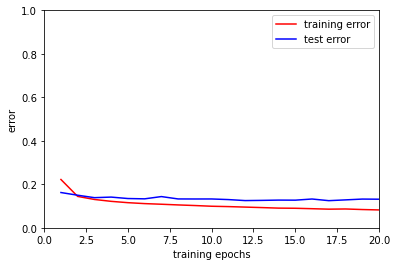

In [52]:
# Network training loop.
for i in range(EPOCHS): # Train EPOCHS iterations
    np.random.shuffle(index_list) # Randomize order
    correct_training_results = 0
    for j in index_list: # Train on all examples
        x = np.concatenate((np.array([1.0]), x_train[j]))
        forward_pass(x)
        if output_layer_y.argmax() == y_train[j].argmax():
            correct_training_results += 1
        backward_pass(y_train[j])
        adjust_weights(x)

    correct_test_results = 0
    for j in range(len(x_test)): # Evaluate network
        x = np.concatenate((np.array([1.0]), x_test[j]))
        forward_pass(x)
        if output_layer_y.argmax() == y_test[j].argmax():
            correct_test_results += 1
    # Show progress.
    show_learning(i, correct_training_results/len(x_train),
                  correct_test_results/len(x_test))
plot_learning() # Create plot
